In [1]:
import argparse
import os
import time

import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from flamby.datasets.fed_tcga_brca import (
    BATCH_SIZE,
    LR,
    NUM_EPOCHS_POOLED,
    Baseline,
    BaselineLoss,
    FedTcgaBrca,
    metric,
)
from flamby.utils import evaluate_model_on_tests
import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

In [11]:
def train_model(
    model,
    optimizer,
    scheduler,
    dataloaders,
    dataset_sizes,
    device,
    lossfunc,
    num_epochs,
    seed,
    log,
    log_period,
):
    """Training function
    Parameters
    ----------
    model : torch model to be trained
    optimizer : torch optimizer used for training
    scheduler : torch scheduler used for training
    dataloaders : dictionary {"train": train_dataloader, "test": test_dataloader}
    dataset_sizes : dictionary {"train": len(train_dataset), "test": len(test_dataset)}
    device : device where model parameters are stored
    lossfunc : function, loss function
    num_epochs : int, number of epochs for training
    seed: int, the sint for the training
    log_period: int, the number of batches between two dumps if log is activated.
    Returns
    -------
    tuple(torch.nn.Module, float) : torch model output by training loop and
    cindex on test.
    """

    since = time.time()

    if log:
        writer = SummaryWriter(log_dir=f"./runs/seed{seed}")

    num_local_steps_per_epoch = len(dataloaders["train"].dataset) // BATCH_SIZE
    num_local_steps_per_epoch += int(
        (len(dataloaders["train"].dataset) - num_local_steps_per_epoch * BATCH_SIZE) > 0
    )
    model = model.train()
    for epoch in range(0, num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-" * 10)

        running_loss = 0.0
        y_true = []
        y_pred = []

        # Iterate over data.
        for idx, (X, y) in enumerate(dataloaders["train"]):
            X = X.to(device)
            y = y.to(device)
            y_true.append(y)

            optimizer.zero_grad()
            outputs = model(X)
            y_pred.append(outputs)
            loss = lossfunc(outputs, y)
            loss.backward()
            optimizer.step()

            current_step = idx + num_local_steps_per_epoch * epoch

            if log and (idx % log_period) == 0:
                writer.add_scalar("Loss/train/client", loss.item(), current_step)

            running_loss += loss.item() * X.size(0)

            scheduler.step()

        epoch_loss = running_loss / dataset_sizes["train"]
        y = torch.cat(y_true)
        y_hat = torch.cat(y_pred)
        epoch_c_index = metric(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
        if log:
            writer.add_scalar("Loss/average-per-epoch/client", epoch_loss, epoch)
            writer.add_scalar("C-index/full-training/client", epoch_c_index, epoch)

        test_dataset = FedTcgaBrca(train=False, pooled=True)
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            # drop_last=True,
        )
        train_c_index.append(evaluate_model_on_tests(model, [test_dataloader], metric, use_tqdm=False)['client_test_0'])
        print(
            "{} Loss: {:.4f} c-index: {:.4f}".format("train", epoch_loss, epoch_c_index)
        )
        

    # Iterate over data.
    dict_cindex = evaluate_model_on_tests(model, [dataloaders["test"]], metric)

    if log:
        writer.add_scalar("Test/C-index", dict_cindex["client_test_0"], 0)

    print()
    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print()

    return model, dict_cindex["client_test_0"]

In [27]:
# torch.use_deterministic_algorithms(False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("device", device)

lossfunc = BaselineLoss()
num_epochs = NUM_EPOCHS_POOLED
log = False
log_period = 10

results0 = []
results1 = []
train_c_index = []
for seed in range(1):
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_dataset = FedTcgaBrca(train=True, pooled=True)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    test_dataset = FedTcgaBrca(train=False, pooled=True)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        # drop_last=True,
    )

    dataloaders = {"train": train_dataloader, "test": test_dataloader}
    dataset_sizes = {"train": len(train_dataset), "test": len(test_dataset)}

    model = Baseline()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[3, 5, 7, 9, 11, 13, 15, 17], gamma=0.5
    )

    results0.append(evaluate_model_on_tests(model, [test_dataloader], metric))

    model, test_cindex = train_model(
        model,
        optimizer,
        scheduler,
        dataloaders,
        dataset_sizes,
        device,
        lossfunc,
        60,
        seed,
        log,
        log_period,
    )
    results1.append(test_cindex)



cpu
device cpu


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.51it/s]

Epoch 0/60
----------


train Loss: 0.1772 c-index: 0.5208
Epoch 1/60
----------
train Loss: 0.1460 c-index: 0.5984
Epoch 2/60
----------
train Loss: 0.1460 c-index: 0.6259
Epoch 3/60
----------
train Loss: 0.1417 c-index: 0.6588
Epoch 4/60
----------
train Loss: 0.1407 c-index: 0.6848
Epoch 5/60
----------
train Loss: 0.1350 c-index: 0.6970
Epoch 6/60
----------
train Loss: 0.1311 c-index: 0.7064
Epoch 7/60
----------
train Loss: 0.1366 c-index: 0.7067
Epoch 8/60
----------
train Loss: 0.1303 c-index: 0.7118
Epoch 9/60
----------
train Loss: 0.1353 c-index: 0.7213
Epoch 10/60
----------
train Loss: 0.1332 c-index: 0.7220
Epoch 11/60
----------
train Loss: 0.1302 c-index: 0.7286
Epoch 12/60
----------
train Loss: 0.1225 c-index: 0.7280
Epoch 13/60
----------
train Loss: 0.1348 c-index: 0.7363
Epoch 14/60
----------
train Loss: 0.1280 c-index: 0.7314
Epoch 15/60
----------
train Loss: 0.1316 c-index: 0.7384
Epoch 16/60
----------
train Loss: 0.1223 c-index: 0.7397
Epoch 17/60
----------
train Loss: 0.1268 c-in

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Training complete in 0m 28s



In [28]:
print("Before training")
print("Test C-index ", results0)
print("Average test C-index ", dict_mean(results0))
print("After training")
print("Test C-index ", results1)
print("Average test C-index ", sum(results1) / len(results1))

Before training
Test C-index  [{'client_test_0': 0.7157509157509158}]
Average test C-index  {'client_test_0': 0.7157509157509158}
After training
Test C-index  [0.8523809523809524]
Average test C-index  0.8523809523809524


In [29]:
train_c_index

[0.46923076923076923,
 0.5421245421245421,
 0.6175824175824176,
 0.6567765567765568,
 0.6934065934065934,
 0.7285714285714285,
 0.736996336996337,
 0.7501831501831502,
 0.7615384615384615,
 0.7673992673992674,
 0.7750915750915751,
 0.7827838827838828,
 0.7864468864468864,
 0.789010989010989,
 0.7963369963369963,
 0.798901098901099,
 0.8014652014652015,
 0.8051282051282052,
 0.8076923076923077,
 0.8113553113553114,
 0.8135531135531135,
 0.8179487179487179,
 0.8212454212454212,
 0.8227106227106227,
 0.8249084249084249,
 0.8245421245421245,
 0.8282051282051283,
 0.8285714285714286,
 0.8322344322344323,
 0.8340659340659341,
 0.8336996336996337,
 0.8344322344322345,
 0.8344322344322345,
 0.8358974358974359,
 0.8373626373626374,
 0.832967032967033,
 0.8417582417582418,
 0.8395604395604396,
 0.8395604395604396,
 0.8399267399267399,
 0.8461538461538461,
 0.8465201465201465,
 0.8454212454212454,
 0.8465201465201465,
 0.8461538461538461,
 0.8476190476190476,
 0.8509157509157509,
 0.8512820512820

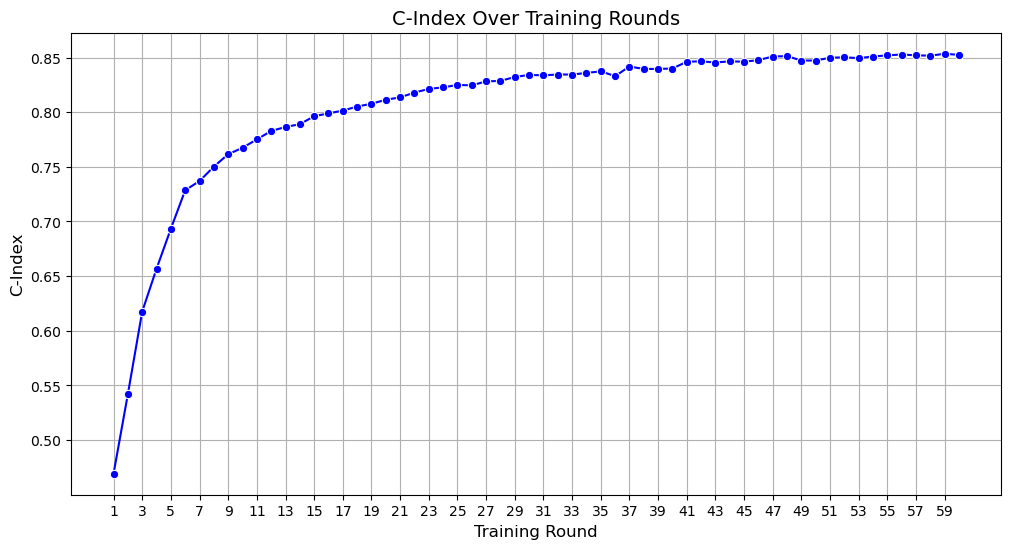

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据
c_index = train_c_index

# 生成横坐标（每个值对应训练轮数）
training_rounds = list(range(1, len(c_index) + 1))

# 绘图
plt.figure(figsize=(12, 6))
sns.lineplot(x=training_rounds, y=c_index, marker='o', color='b')

# 添加标题和标签
plt.title('C-Index Over Training Rounds', fontsize=14)
plt.xlabel('Training Round', fontsize=12)
plt.ylabel('C-Index', fontsize=12)
plt.xticks(training_rounds[::2])  # 每隔 2 个轮次显示一个横坐标
plt.grid(True)

# 显示图形
plt.show()